# PCA for data on average monthly rent and noise exposure of the population of the city of Barcelona

Task for the hackathon within **Jump2digital 2023**.

**Objective**  
Reduce the dimensionality of the combined dataset containing data on average monthly rent and population noise exposure in the city of Barcelona through Principal Component Analysis (PCA).

**Data description**  
There are two datasets for 2017 provided by the [Open Data BCN](https://opendata-ajuntament.barcelona.cat/en/) - Open Data Service of the Barcelona City Council.

1. Base dataset  
["Average monthly rent of the city of Barcelona"](https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-mercat-immobiliari-lloguer-mitja-mensual/resource/0a71a12d-55fa-4a76-b816-4ee55f84d327)
- Any - Year of the data
- Trimestre - Quarter of the data
- Codi_Districte - District code
- Nom_Districte - District name
- Codi_Barri - Neighbourhood code
- Nom_Barri - Neighbourhood name
- Lloguer_mitja - Type of rental price: average monthly rent or average monthly rent per m2.
- Preu - Rental price
2. Additional dataset  
["Exposed population to the noise levels from Strategic Noise Map of the city of Barcelona"](https://opendata-ajuntament.barcelona.cat/data/en/dataset/poblacio-exposada-mapa-estrategic-soroll/resource/3846500e-72aa-4780-967f-f09aa184eaba)  
Exposed population data determine the percentages of the population exposed to the different noise ranges, according to the type of source and the time period. A Strategic Noise Map (SNM) is a set of maps that serve to globally assess the population's exposure to noise produced by different noise sources in a given area, and to serve as the basis for the development of action plans. They are used as a management tool to fight noise pollution and are **developed every 5 years**.  
Population data comes from the reading of the municipal register the corresponding year. The percentages shown are with respect the population of the neighbourhood, district or city, according to the corresponding resource.  
For noise evaluation there are three time periods: **day (D**, from 7 am to 9 pm), **evening (E**, from 9 pm to 11 pm), and **night (N**, from 11 pm to 7 am). In addition, there is a fourth indicator, the weighted **day-evening-night (DEN)**, which corresponds to a weighted average of the D, E and N indicators, penalizing the evening and night periods.

- Codi_Districte - District code
- Nom_Districte - District name
- Codi_Barri - Neighbourhood code
- Nom_Barri - Neighbourhood name
- Concepte - Concept: 
    - TOTAL_D, E, N, DEN - Total noise in day, evening, night periods or weighted day-evening-night
    - TRANSIT_D, E, N, DEN - Road traffic noise in day, evening, night periods or weighted day-evening-night
    - GI_TR_D, E, N, DEN - Major road traffic noise in day period in day, evening, night periods or weighted day-evening-night
    - FFCC_D - D, E, N, DEN - Railway noise in day, evening, night periods or weighted day-evening-night
    - INDUST_D, E, N, DEN - Industrial noise in day, evening, night periods or weighted day-evening-night
    - VIANANTS_D, E, - Noise in pedestrian streets in day, evening periods
    - OCI_N - Recreational noise in night period
    - PATIS_D, E - Noise in inner courtyards in day, evening periods
    - PARCS_D - Noise in parks in day period
- Rang_soroll - Noise range
- Valor - the percentages of the population exposed to the specific noise ranges

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Load" data-toc-modified-id="Data-Load-1">Data Load</a></span></li><li><span><a href="#Pre-processing-and-EDA" data-toc-modified-id="Pre-processing-and-EDA-2">Pre-processing and EDA</a></span><ul class="toc-item"><li><span><a href="#Dataset-with-rental-prices" data-toc-modified-id="Dataset-with-rental-prices-2.1">Dataset with rental prices</a></span><ul class="toc-item"><li><span><a href="#Reshape-data" data-toc-modified-id="Reshape-data-2.1.1">Reshape data</a></span></li><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-2.1.2">Missing values</a></span></li></ul></li><li><span><a href="#Dataset-with-percentage-of-the-population-exposed-to-different-types-of-noise" data-toc-modified-id="Dataset-with-percentage-of-the-population-exposed-to-different-types-of-noise-2.2">Dataset with percentage of the population exposed to different types of noise</a></span><ul class="toc-item"><li><span><a href="#Reshape-data" data-toc-modified-id="Reshape-data-2.2.1">Reshape data</a></span></li></ul></li><li><span><a href="#Merge-dataframes" data-toc-modified-id="Merge-dataframes-2.3">Merge dataframes</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span><ul class="toc-item"><li><span><a href="#Data-standartization" data-toc-modified-id="Data-standartization-3.1">Data standartization</a></span></li><li><span><a href="#Linear-correlation-between-features" data-toc-modified-id="Linear-correlation-between-features-3.2">Linear correlation between features</a></span></li><li><span><a href="#Transform-the-data" data-toc-modified-id="Transform-the-data-3.3">Transform the data</a></span></li></ul></li><li><span><a href="#Conclusion:" data-toc-modified-id="Conclusion:-4">Conclusion:</a></span></li></ul></div>

In [1]:
# importing libraries 
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# display settings
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

%matplotlib inline

In [3]:
# plt.style.use
sns.set_style("darkgrid")

# figure parameters
small, medium, large = 14, 16, 20
params = {'figure.titlesize': large,
          'legend.fontsize':  small,
          'axes.titlesize':   medium,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small}
plt.rcParams.update(params)

In [4]:
# Check versions of libraries
def lib_versions(libs):
    for lib in libs: print('Version', lib.__name__, '-', lib.__version__)

lib_versions([np, pd, mpl, sns])

Version numpy - 1.21.5
Version pandas - 1.4.2
Version matplotlib - 3.5.1
Version seaborn - 0.11.2


## Data Load

In [5]:
# create lists with dataset file-names and urls
filnames = ['2017_lloguer_preu_trim.csv', 
            '2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv']

urls = ['https://opendata-ajuntament.barcelona.cat/data/dataset/69c3250b-100c-4d5b-a08e-0a191d9950e3/resource/0a71a12d-55fa-4a76-b816-4ee55f84d327/download/2017_lloguer_preu_trim.csv',
        'https://opendata-ajuntament.barcelona.cat/data/dataset/5dfda160-9faa-4a7c-b8fe-c974904ea43b/resource/3846500e-72aa-4780-967f-f09aa184eaba/download/2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv']

In [6]:
# define function to read files and display information about the data
def read_file(filename, url):
    """Input: strings with file name and its url.
    Function reads data, displays basic information, 
    checks for duplicates and NaN. 
    Output: Dataframe.
    """
    
    # reading file
    try:
        df = pd.read_csv(filename)
    except:
        df = pd.read_csv(url)
    
    # get first and last 5 rows
    display(df)
    
    # get information about the data
    print()
    print(df.info())
    
    # number of unique values for each column
    print()
    print('\033[1mNumber of unique values')
    display(df.nunique())
    
    # check for duplicates
    print()
    if df.duplicated().sum() > 0:
        print('Data contain full duplicates\n')
    else:
        print('There are no full duplicates in the data\n')
    
    # check for NaN
    if df.isna().sum().sum() > 0:
        print('Data contain NaN\n')
    else:
        print('There are no NaNs in the data\n')
        
    return df

In [7]:
# apply function to get first dataset
df_rent = read_file(filnames[0], urls[0])

,Any,Trimestre,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Lloguer_mitja,Preu
0,2017,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,2017,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78
3,2017,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Lloguer mitjà mensual (Euros/mes),895.28
4,2017,1,2,Eixample,5,el Fort Pienc,Lloguer mitjà mensual (Euros/mes),871.08
...,...,...,...,...,...,...,...,...
579,2017,4,10,Sant Martí,69,Diagonal Mar i el Front Marítim del Poblenou,Lloguer mitjà per superfície (Euros/m2 mes),16.51
580,2017,4,10,Sant Martí,70,el Besòs i el Maresme,Lloguer mitjà per superfície (Euros/m2 mes),10.40
581,2017,4,10,Sant Martí,71,Provençals del Poblenou,Lloguer mitjà per superfície (Euros/m2 mes),12.66
582,2017,4,10,Sant Martí,72,Sant Martí de Provençals,Lloguer mitjà per superfície (Euros/m2 mes),10.83



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Any             584 non-null    int64  
 1   Trimestre       584 non-null    int64  
 2   Codi_Districte  584 non-null    int64  
 3   Nom_Districte   584 non-null    object 
 4   Codi_Barri      584 non-null    int64  
 5   Nom_Barri       584 non-null    object 
 6   Lloguer_mitja   584 non-null    object 
 7   Preu            546 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 36.6+ KB
None

Number of unique values


Any                 1
Trimestre           4
Codi_Districte     10
Nom_Districte      10
Codi_Barri         73
Nom_Barri          73
Lloguer_mitja       2
Preu              504
dtype: int64


There are no full duplicates in the data

Data contain NaN



In [8]:
# Translate column names from Catalan to English
df_rent.columns = ['Year', 'Quarter', 'District_code', 'District_name', 
                   'Neighbourhood_code', 'Neighbourhood_name', 
                   'Rental_price_type', 'Price']
df_rent.head(3)

,Year,Quarter,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Rental_price_type,Price
0,2017,1,1,Ciutat Vella,1,el Raval,Lloguer mitjà mensual (Euros/mes),734.99
1,2017,1,1,Ciutat Vella,2,el Barri Gòtic,Lloguer mitjà mensual (Euros/mes),905.26
2,2017,1,1,Ciutat Vella,3,la Barceloneta,Lloguer mitjà mensual (Euros/mes),722.78


In [9]:
# Number of neighborhoods in each district
df_rent.groupby('District_name').Neighbourhood_name.nunique()

District_name
Ciutat Vella            4
Eixample                6
Gràcia                  5
Horta-Guinardó         11
Les Corts               3
Nou Barris             13
Sant Andreu             7
Sant Martí             10
Sants-Montjuïc          8
Sarrià-Sant Gervasi     6
Name: Neighbourhood_name, dtype: int64

In the dataset with rental prices, there is data for all 10 districts and their 73 neighborhoods for the year 2017. For each neighborhood, the average rental price (total and per m2) is provided for each quarter. The data contains missing values - not all neighborhoods have rental price data, or there are missing values for certain quarters.  
Various districts have a different number of neighborhoods, and the data corresponds to [official sources](https://www.barcelona.cat/en/living-in-bcn/living-neighbourhood).

In [10]:
# apply function to get the second dataset
df_noise = read_file(filnames[1], urls[1])

,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Concepte,Rang_soroll,Valor
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97%
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85%
...,...,...,...,...,...,...,...
18975,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,60-65 dB,0.00%
18976,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,65-70 dB,0.00%
18977,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,70-75 dB,0.00%
18978,10,Sant Martí,73,la Verneda i la Pau,PARCS_D,75-80 dB,0.00%



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Codi_Districte  18980 non-null  int64 
 1   Nom_Districte   18980 non-null  object
 2   Codi_Barri      18980 non-null  int64 
 3   Nom_Barri       18980 non-null  object
 4   Concepte        18980 non-null  object
 5   Rang_soroll     18980 non-null  object
 6   Valor           18980 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB
None

Number of unique values


Codi_Districte      10
Nom_Districte       10
Codi_Barri          73
Nom_Barri           73
Concepte            26
Rang_soroll         10
Valor             3104
dtype: int64


There are no full duplicates in the data

There are no NaNs in the data



In [11]:
# Translate column names from Catalan to English
df_noise.columns = ['District_code', 'District_name', 
                   'Neighbourhood_code', 'Neighbourhood_name', 
                   'Concept', 'Noise_range', 'Percentage_population']
df_noise.head(3)

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Concept,Noise_range,Percentage_population
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73%
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98%
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38%


In [12]:
# Number of neighborhoods in each district
df_noise.groupby('District_name').Neighbourhood_name.nunique()

District_name
Ciutat Vella            4
Eixample                6
Gràcia                  5
Horta-Guinardó         11
Les Corts               3
Nou Barris             13
Sant Andreu             7
Sant Martí             10
Sants-Montjuïc          8
Sarrià-Sant Gervasi     6
Name: Neighbourhood_name, dtype: int64

In the dataset with data on the population exposed to various types of noise, there is also information for all 10 districts and all 73 neighborhoods. The data covers the period from 2012 to 2017. There are 26 "types of noise" (`Concept`) and 10 noise levels. In total, there are 18,980 rows, which means that there is data for each neighborhood for all types of noise at all levels (73 * 26 * 10). The format of the column with the percentage of the exposed population (`Percentage_population`) should be changed to a numeric one. The data contains no missing values. 

## Pre-processing and EDA
### Dataset with rental prices

First, we will remove unnecessary columns, reshape the data into a 'wide format,' and handle missing values.

In the column `Year`, the only value is 2017. Let's remove this column.

In [13]:
# drop column with the year
df_rent=df_rent.drop('Year', axis=1)

#### Reshape data

In [14]:
# unique values in the 'Rental_price_type' column
df_rent.Rental_price_type.unique()

array(['Lloguer mitjà mensual (Euros/mes)',
       'Lloguer mitjà per superfície (Euros/m2 mes)'], dtype=object)

In [15]:
# reshape data to the wide format
# 'Rental_price_type' -> 'Price' and 'Price_m2'
df_rent = (df_rent.pivot(
    index=df_rent.columns[0:-2],
    columns='Rental_price_type',
    values='Price')
        .reset_index()              # collapses multi-index
        .rename_axis(None, axis=1)  # renames index
        .rename(columns={'Lloguer mitjà mensual (Euros/mes)': 'Price',
                         'Lloguer mitjà per superfície (Euros/m2 mes)': 'Price_m2'})
       )
df_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Quarter             292 non-null    int64  
 1   District_code       292 non-null    int64  
 2   District_name       292 non-null    object 
 3   Neighbourhood_code  292 non-null    int64  
 4   Neighbourhood_name  292 non-null    object 
 5   Price               273 non-null    float64
 6   Price_m2            273 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 16.1+ KB


Now, for each neighborhood, there is information on the average rental price and the average price per square meter for each quarter. But there are 19 rows where this information is missing.

#### Missing values

In [16]:
# Number of Nan for each column
df_rent.isna().sum()

Quarter                0
District_code          0
District_name          0
Neighbourhood_code     0
Neighbourhood_name     0
Price                 19
Price_m2              19
dtype: int64

In [17]:
df_rent[df_rent.Price.isna()]

,Quarter,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Price,Price_m2
11,1,3,Sants-Montjuïc,12,la Marina del Prat Vermell,NaN,NaN
41,1,7,Horta-Guinardó,42,la Clota,NaN,NaN
46,1,8,Nou Barris,47,Can Peguera,NaN,NaN
55,1,8,Nou Barris,56,Vallbona,NaN,NaN
57,1,9,Sant Andreu,58,Baró de Viver,NaN,NaN
84,2,3,Sants-Montjuïc,12,la Marina del Prat Vermell,NaN,NaN
114,2,7,Horta-Guinardó,42,la Clota,NaN,NaN
126,2,8,Nou Barris,54,Torre Baró,NaN,NaN
130,2,9,Sant Andreu,58,Baró de Viver,NaN,NaN
157,3,3,Sants-Montjuïc,12,la Marina del Prat Vermell,NaN,NaN


In [18]:
print('\033[1mNumber of quarters without rent:')
(4-df_rent.groupby('Neighbourhood_name').Price.count()[
    df_rent.groupby('Neighbourhood_name').Price.count() < 4])

Number of quarters without rent:


Neighbourhood_name
Baró de Viver                 4
Can Peguera                   3
Torre Baró                    1
Vallbona                      3
la Clota                      4
la Marina del Prat Vermell    4
Name: Price, dtype: int64

There are three neighborhoods in which, presumably, no housing was rented out in 2017, or this information is missing. In three other neighborhoods, the information is not available for all quarters. Let's decide to remove these rows.

In [19]:
# Drop rows with Nan
df_rent = df_rent.dropna()
df_rent.isna().sum().sum()

0

The rental price depends on the rental price of square meter in a specific neighborhood and the area of the apartment. Let's calculate the average rental property area for each neighborhood.

In [20]:
# Calculate average rental area from Price and Price per Square Meter
df_rent['Area'] = df_rent['Price'] / df_rent['Price_m2']

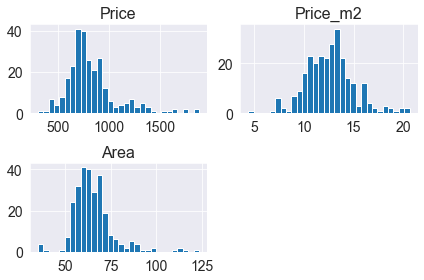

In [21]:
# distribution histograms
df_rent[['Price', 'Price_m2', 'Area']].hist(bins=30)
plt.tight_layout()
plt.show()

In [22]:
# descriptive statistics
df_rent[['Price', 'Price_m2', 'Area']].describe()

,Price,Price_m2,Area
count,273.00,273.00,273.00
mean,829.38,12.64,65.23
std,253.21,2.48,11.76
min,302.52,4.45,34.86
25%,680.80,11.00,58.42
50%,771.78,12.64,63.62
75%,912.51,13.97,69.41
max,1882.42,20.61,123.32


The distribution of rental prices is skewed to the right - in some neighbourhoods, prices are much higher. In most neighbourhoods, the price falls between 500 and 1000 euros, and there is also a subgroup of neighbourhoods with prices between 1000-1500. The distribution of prices per square meter is more symmetrical; for most neighbourhoods, the rental price per square meter does not exceed 14 euros.

Let's see how much the price depends on the quarter.

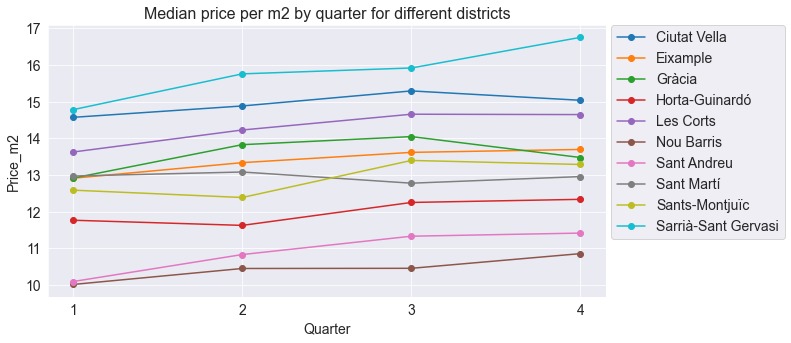

In [23]:
# Pivot the DataFrame to have 'Quarter' as rows and 'District_name' as rows
result = df_rent.pivot_table(columns='District_name', 
                             index='Quarter', 
                             values='Price_m2', 
                             aggfunc='median')

# Plot the data
result.plot(style='-o', legend=True, figsize=(10,5), xticks=result.index)
plt.xlabel('Quarter')
plt.ylabel('Price_m2')
plt.title('Median price per m2 by quarter for different districts')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

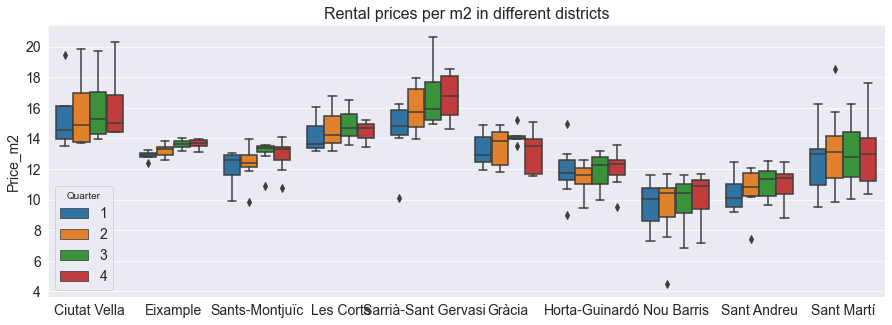

In [24]:
# Boxplots of price_m2 by district and quarter
plt.figure(figsize=(15,5))
sns.boxplot(x=df_rent['District_name'], y=df_rent['Price_m2'], 
            hue=df_rent['Quarter'])
plt.title('Rental prices per m2 in different districts')
plt.xlabel(None)
plt.show()

In [25]:
# descriptive statistics
df_rent.groupby('Quarter')[['Price', 'Price_m2', 'Area']].describe()

Price                                                   Price_m2  \
        count   mean    std    min    25%    50%    75%     max    count   
Quarter                                                                    
1       68.00 808.43 246.50 418.07 668.39 738.31 895.57 1856.57    68.00   
2       69.00 812.47 255.90 302.52 671.87 756.13 902.42 1666.63    69.00   
3       68.00 855.02 265.39 423.09 703.80 797.10 928.75 1882.42    68.00   
4       68.00 841.85 247.13 425.51 693.59 776.97 912.03 1737.92    68.00   

                                                 Area                          \
         mean  std  min   25%   50%   75%   max count  mean   std   min   25%   
Quarter                                                                         
1       12.26 2.28 7.26 10.50 12.46 13.28 19.46 68.00 65.71 13.69 37.14 56.98   
2       12.48 2.62 4.45 10.82 12.28 13.83 19.87 69.00 64.65 10.82 34.86 59.06   
3       12.93 2.51 6.84 11.09 13.13 14.08 20.61 68.00 65.67 11.80 38.45 58.77   
4       12.89 2.47 7.17 11.35 12.79 14.01 20.33 68.00 64.87 10.74 37.68 58.49   

                            
          50%   75%    max  
Quarter                     
1       64.03 69.47 123.32  
2       63.50 69.91  99.44  
3       63.85 69.22 113.81  
4       63.33 68.88 114.19

Overall, the price per square meter for housing rentals appears to increase over the course of the year, especially in the 3rd quarter, which makes sense as it's the peak tourist season. However, the changes are not uniform across different districts. In general, it seems that the quarter has an impact on the rental price and should be taken into consideration.

Let's take a look at the price variation per square meter depending on the neighbourhood; it's possible that prices are roughly the same in each district.

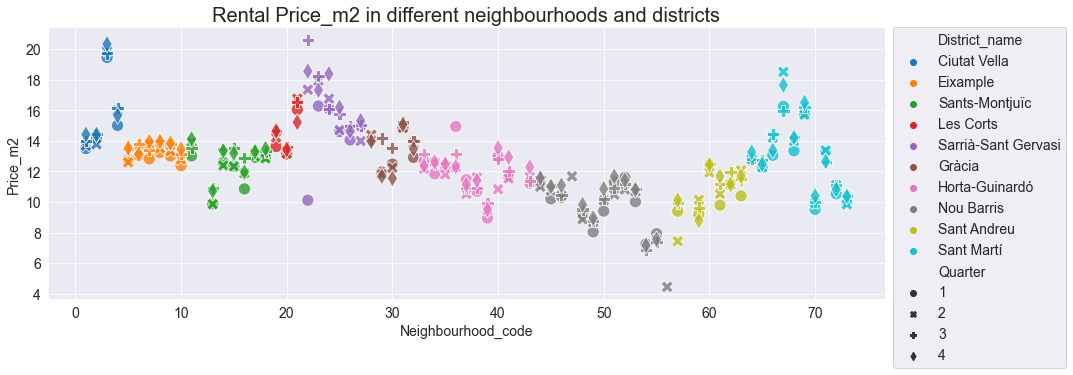

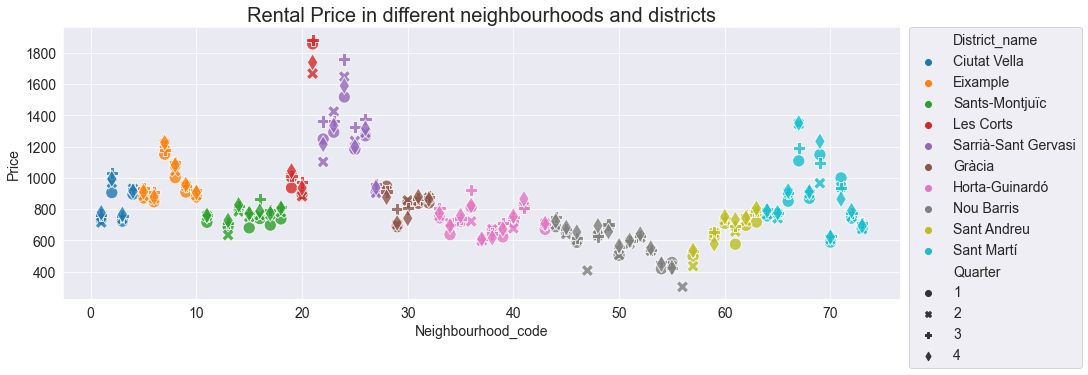

In [26]:
# scatterplots
for col in ['Price_m2', 'Price']:
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=df_rent, x='Neighbourhood_code', y=col, 
                    hue='District_name', style='Quarter', 
                    markers=['o', 'X', 'P', 'd'],
                    s=150, alpha=0.8)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.title(f'Rental {col} in different neighbourhoods and districts', fontsize=20)
    plt.show()

We can see that only in the Eixample district, the prices are approximately the same across all neighborhoods, while in the other districts, there are both expensive and cheaper neighborhoods. The price variation between quarters is generally small, but occasionally, it's quite pronounced.

It can be said that it's challenging to judge the price per square meter by district; a more accurate indicator is the neighborhood.

Let's take a look at the most expensive and the cheapest districts/neighborhoods.

In [27]:
# Sort districts per median price_m2
df_rent.groupby('District_name')[
    ['Price_m2', 'Price', 'Area']
].median().sort_values(by='Price_m2', ascending=False)

,Price_m2,Price,Area
District_name,,,
Sarrià-Sant Gervasi,15.92,1289.37,80.19
Ciutat Vella,14.72,836.00,56.06
Les Corts,14.44,1010.21,71.00
Gràcia,13.90,854.13,62.83
Eixample,13.38,928.00,69.99
Sants-Montjuïc,12.94,763.51,60.69
Sant Martí,12.87,824.22,65.94
Horta-Guinardó,11.93,711.78,59.30
Sant Andreu,11.14,702.32,62.50


In [28]:
# Top-10 most expensive neighborhoods
df_rent.groupby(['District_name', 'Neighbourhood_name'])[
    ['Price_m2', 'Price', 'Area']
].median().sort_values(by='Price_m2', ascending=False).head(10)

Price_m2  \
District_name       Neighbourhood_name                                       
Ciutat Vella        la Barceloneta                                   19.80   
Sarrià-Sant Gervasi Vallvidrera, el Tibidabo i les Planes            17.95   
                    Sarrià                                           17.62   
Sant Martí          la Vila Olímpica del Poblenou                    16.95   
Sarrià-Sant Gervasi les Tres Torres                                  16.44   
Les Corts           Pedralbes                                        16.30   
Sant Martí          Diagonal Mar i el Front Marítim del Poblenou     16.00   
Ciutat Vella        Sant Pere, Santa Caterina i la Ribera            15.82   
Sarrià-Sant Gervasi Sant Gervasi - la Bonanova                       15.24   
                    el Putxet i el Farró                             14.99   

                                                                   Price  \
District_name       Neighbourhood_name                                     
Ciutat Vella        la Barceloneta                                748.21   
Sarrià-Sant Gervasi Vallvidrera, el Tibidabo i les Planes        1230.97   
                    Sarrià                                       1349.39   
Sant Martí          la Vila Olímpica del Poblenou                1267.45   
Sarrià-Sant Gervasi les Tres Torres                              1617.64   
Les Corts           Pedralbes                                    1797.24   
Sant Martí          Diagonal Mar i el Front Marítim del Poblenou 1120.77   
Ciutat Vella        Sant Pere, Santa Caterina i la Ribera         920.97   
Sarrià-Sant Gervasi Sant Gervasi - la Bonanova                   1217.22   
                    el Putxet i el Farró                          925.83   

                                                                   Area  
District_name       Neighbourhood_name                                   
Ciutat Vella        la Barceloneta                                37.42  
Sarrià-Sant Gervasi Vallvidrera, el Tibidabo i les Planes         65.71  
                    Sarrià                                        78.20  
Sant Martí          la Vila Olímpica del Poblenou                 73.58  
Sarrià-Sant Gervasi les Tres Torres                               96.17  
Les Corts           Pedralbes                                    114.00  
Sant Martí          Diagonal Mar i el Front Marítim del Poblenou  70.06  
Ciutat Vella        Sant Pere, Santa Caterina i la Ribera         58.29  
Sarrià-Sant Gervasi Sant Gervasi - la Bonanova                    82.47  
                    el Putxet i el Farró                          62.68

In [29]:
# Top-10 cheapest neighbourhoods
df_rent.groupby(['District_name', 'Neighbourhood_name'])[
    ['Price_m2', 'Price', 'Area']
].median().sort_values(by='Price_m2').head(10)

Price_m2  Price  Area
District_name  Neighbourhood_name                             
Nou Barris     Vallbona                      4.45 302.52 67.98
               Torre Baró                    7.17 448.23 62.51
               Ciutat Meridiana              7.54 430.84 57.59
               Canyelles                     8.73 683.56 78.93
               la Guineueta                  9.32 633.48 70.02
Sant Andreu    el Bon Pastor                 9.43 635.26 66.63
Horta-Guinardó Sant Genís dels Agudells      9.50 676.75 71.14
Sant Andreu    la Trinitat Vella             9.67 515.09 53.26
Sant Martí     el Besòs i el Maresme         9.97 613.97 61.50
Nou Barris     les Roquetes                 10.16 533.26 52.82

The most expensive district, both in terms of the total price and price per square meter, is *Sarrià-Sant Gervasi*, while the cheapest is *Nou Barris*. When looking at neighborhoods, the most expensive neighborhood (*La Barceloneta*) in terms of price per square meter is not the most expensive in terms of the total rental price (*Pedralbes*), which indicates variations in the size of properties rented in different neighborhoods. Conversely, the chepest neighborhood, *Vallbona*, is the cheapest in both total rental price and price per square meter.

Let's save the codes for the most expensive and the cheapest district and neighborhood, as well as the codes for the top 10 most expensive and cheapest neighborhoods. For the most expensive neighborhood, we'll choose the one with the highest price per square meter in the most expensive district (*Vallvidrera, el Tibidabo i les Planes*).

In [30]:
# Codes of the the most expensive district and neighbourhood
expensive_distr = (df_rent
                   .groupby('District_code')
                   .Price_m2.median().idxmax())
expensive_nbhood = (df_rent[df_rent['District_code'] == expensive_distr]
                    .groupby('Neighbourhood_code')
                    .Price_m2.median().idxmax())

# Codes of the the cheapest district and neighbourhood
cheap_distr = (df_rent
               .groupby('District_code')
               .Price_m2.median().idxmin())

cheap_nbhood = (df_rent
                .groupby('District_code')
                .Price_m2.median().idxmin())

In [31]:
# Codes of the Top-10 most expensive neighbourhoods
expensive_nbhood_10 = (list(df_rent
                            .groupby('Neighbourhood_code')
                            .Price_m2
                            .median()
                            .sort_values(ascending=False)
                            .head(10).index))

# Codes of the Top-10 cheapest neighbourhoods
cheap_nbhood_10 = (list(df_rent
                        .groupby('Neighbourhood_code')
                        .Price_m2
                        .median()
                        .sort_values()
                        .head(10).index))

**Conclusion**:   
We have information about rental prices (total price and price per square meter) for 73 neighborhoods in Barcelona belonging to 10 districts for the four quarters of 2017.
- Based on the total price and price per square meter, a new feature, 'Area,' was created;
- For some neighborhoods and quarters, there was missing price information, and such rows were removed;
- Rental prices, in general, depend on the quarter, but for some neighborhoods, the price difference between quarters can be much more pronounced than for others;
- Rental prices can vary significantly among neighborhoods within the same district, sometimes being higher due to larger property sizes being rented. Overall, price is more influenced by the neighborhood rather than the district;
- the most expensive district (*Sarrià-Sant Gervasi*) and neighborhood (*Vallvidrera, el Tibidabo i les Planes*), and the least expensive district (*Nou Barris*) and  neighborhood (*Vallbona*) were identified, as well as the top 10 most expensive and least expensive neighborhoods.

### Dataset with percentage of the population exposed to different types of noise

Noise is an important public health issue. It has negative impacts on human health and well-being and is a growing concern. The latest studies by the WHO and the EEA clearly show the impact that noise pollution has on people’s quality of life. Elevated levels of noise may cause annoyance and sleep disturbance, and potentially incidence of stroke and diabetes. The WHO Regional Office for Europe has therefore developed [environmental noise guidelines](https://www.who.int/europe/publications/i/item/9789289053563) for the European Region, proposing an updated set of public health recommendations on exposure to environmental noise. For example, for average noise exposure, it is strongly recommended to reduce noise levels produced by road traffic **below 53 dB (DEN)**, and for **night noise exposure - below 45 dB**. The road traffic noise above these levels is associated with adverse health effects.

Thus, it can be sopposed that rental prices may be related, among other factors, to the noise levels in the neighborhoods. 

Let's correct data types and transform the dataset from a long format to a wide format.

In [32]:
# Convert "Percentage_population" to float 
df_noise['Percentage_population'] = (df_noise['Percentage_population']
                                     .str.rstrip('%')
                                     .astype('float'))
df_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18980 entries, 0 to 18979
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   District_code          18980 non-null  int64  
 1   District_name          18980 non-null  object 
 2   Neighbourhood_code     18980 non-null  int64  
 3   Neighbourhood_name     18980 non-null  object 
 4   Concept                18980 non-null  object 
 5   Noise_range            18980 non-null  object 
 6   Percentage_population  18980 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.0+ MB


In [33]:
# noise ranges
df_noise.Noise_range.unique()

array(['<40 dB', '40-45 dB', '45-50 dB', '50-55 dB', '55-60 dB',
       '60-65 dB', '65-70 dB', '70-75 dB', '75-80 dB', '>=80 dB'],
      dtype=object)

In [34]:
df_noise[(df_noise['Neighbourhood_code']==expensive_nbhood) & (df_noise['Concept']=='PARCS_D')]

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Concept,Noise_range,Percentage_population
18460,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,<40 dB,100.00
18461,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,40-45 dB,0.00
18462,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,45-50 dB,0.00
18463,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,50-55 dB,0.00
18464,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,55-60 dB,0.00
18465,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,60-65 dB,0.00
18466,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,65-70 dB,0.00
18467,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,70-75 dB,0.00
18468,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,75-80 dB,0.00
18469,5,Sarrià-Sant Gervasi,22,"Vallvidrera, el Tibidabo i les Planes",PARCS_D,>=80 dB,0.00


It can be seen that for each "noise concept", there are 10 volume levels with a 5 dB increment. 

Let's examine, for each concept, the percentages of the population exposed to the different noise ranges.

<a id='scatterplots_1'></a>

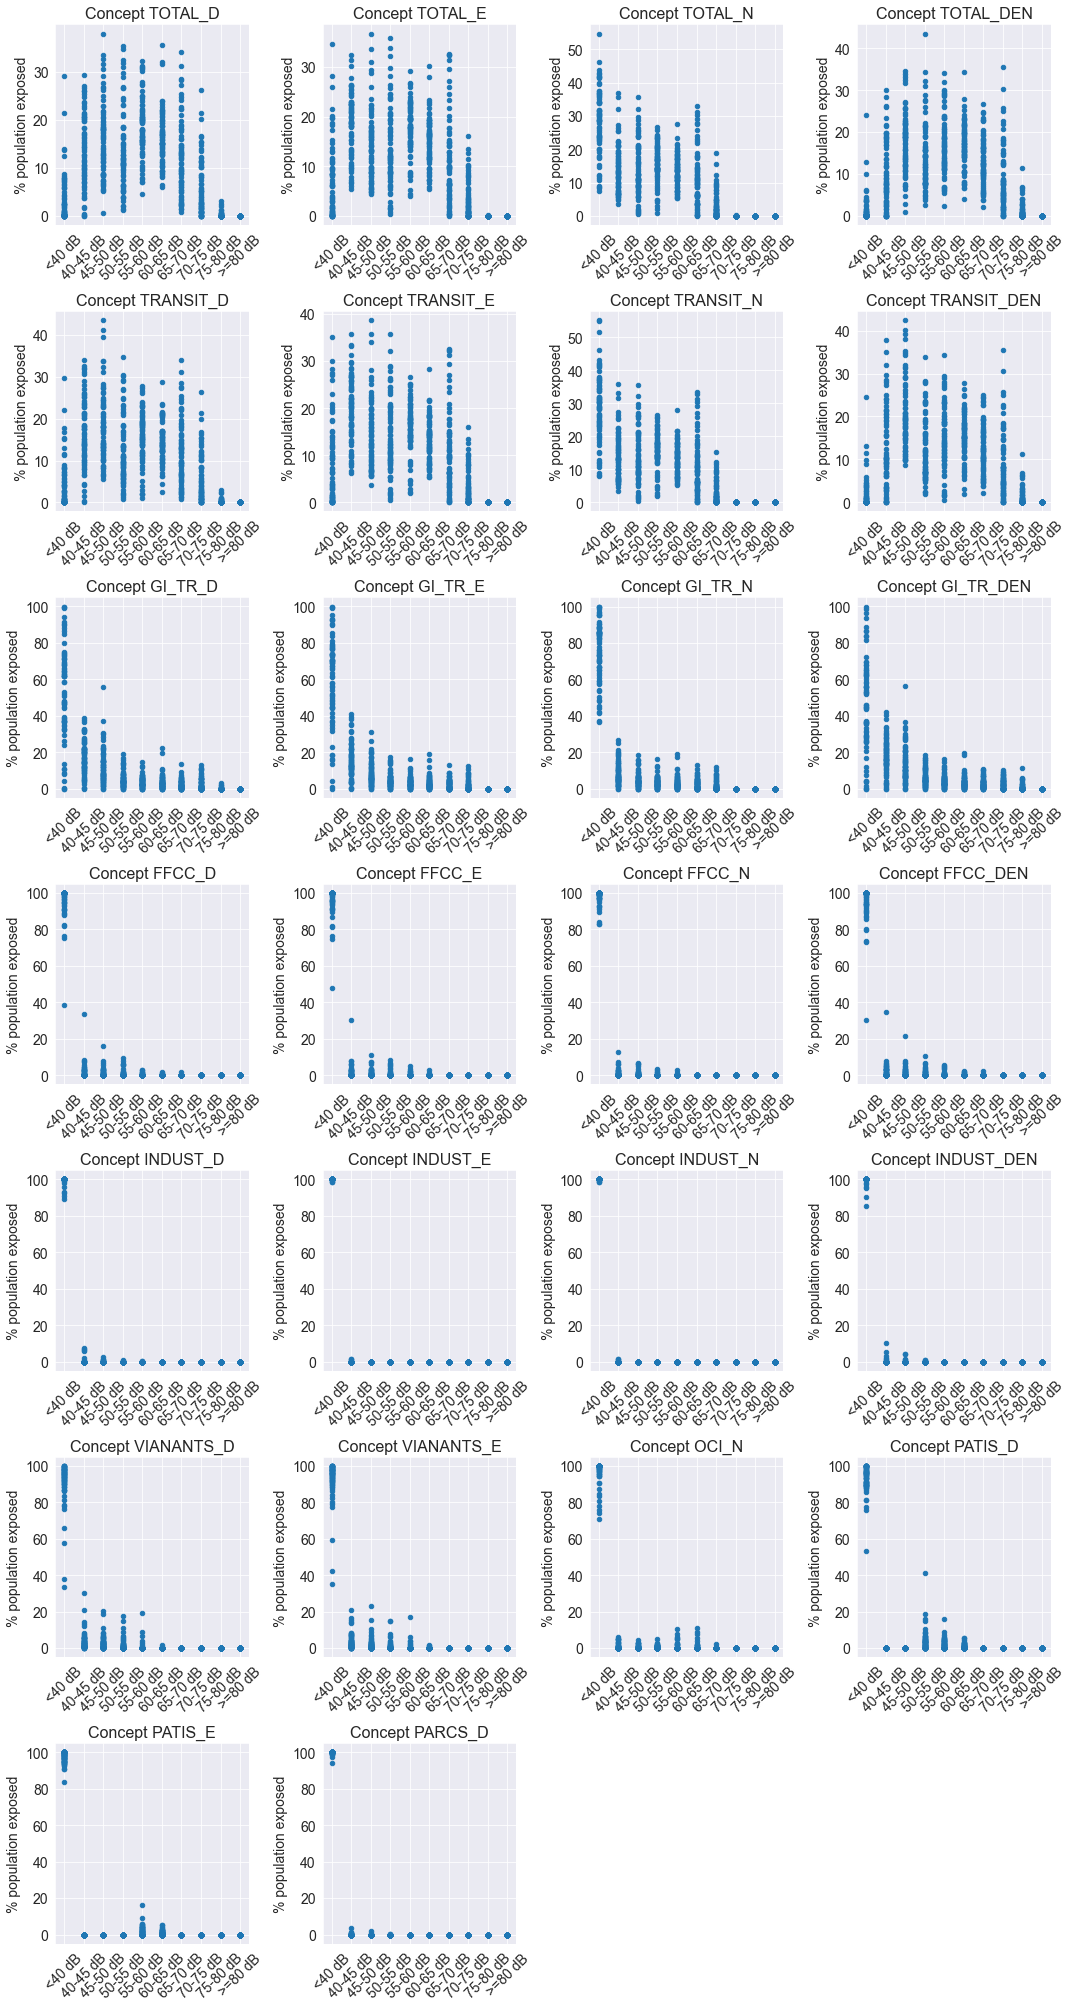

In [35]:
# Scatterplots for each type of noise source and time period
fig = plt.figure(figsize=(15, 28))
for i, concept in enumerate(list(df_noise.Concept.unique())):
    ax=plt.subplot(7, 4, i+1)  
    df_noise[df_noise['Concept'] == concept].plot(
        x='Noise_range', y='Percentage_population',
        kind='scatter', rot=45, ax=ax)
    plt.title(f'Concept {concept}')
    plt.xlabel(None)
    plt.ylabel('% population exposed')
    plt.tight_layout()

It is evident that noise exposure varies across different neighborhoods. In some neighborhoods, a significant percentage of the population is hardly exposed to noise during the night, while in others, over 30% suffer from nighttime noise levels exceeding 60 dB. The highest percentage of the population is exposed to road traffic noise  (TRANSIT), while industrial noise is very low. The population does not appear to be exposed to very loud noise levels exceeding 80 dB. It may be possible to group noise levels into broader ranges.  
In addition to the time-based division of noise (day, evening, night), there is an aggregate indicator, the weighted day-evening-night (DEN), which corresponds to a weighted average of the day, evening and night indicators. Sometimes, its values may seem unusual. For example, when the percentage of the exposed population is not zero during the day, evening, and night, how can it be zero in aggregate? Let's investigate such cases.

In [36]:
# Neighbourhoods where percentage of population exposed 
# to transit noise at day+evening+night (DEN) = 0
df_noise[(df_noise['Concept']=='TRANSIT_DEN') & 
         (df_noise['Percentage_population']<0.01) &
         (df_noise['Noise_range']=='40-45 dB')]

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Concept,Noise_range,Percentage_population
5161,2,Eixample,6,la Sagrada Família,TRANSIT_DEN,40-45 dB,0.00
5171,2,Eixample,7,la Dreta de l'Eixample,TRANSIT_DEN,40-45 dB,0.00
5181,2,Eixample,8,l'Antiga Esquerra de l'Eixample,TRANSIT_DEN,40-45 dB,0.00
5671,9,Sant Andreu,57,la Trinitat Vella,TRANSIT_DEN,40-45 dB,0.00


In [37]:
# Neighbourhoods 6 and 57 
df_noise[(df_noise['Neighbourhood_code'].isin([6, 57])) & 
         (df_noise['Concept'].str.contains('TRANSIT')) &
         (df_noise['Noise_range']=='40-45 dB')].sort_values(by='Neighbourhood_code')

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Concept,Noise_range,Percentage_population
2971,2,Eixample,6,la Sagrada Família,TRANSIT_D,40-45 dB,2.63
3701,2,Eixample,6,la Sagrada Família,TRANSIT_E,40-45 dB,22.11
4431,2,Eixample,6,la Sagrada Família,TRANSIT_N,40-45 dB,21.20
5161,2,Eixample,6,la Sagrada Família,TRANSIT_DEN,40-45 dB,0.00
3481,9,Sant Andreu,57,la Trinitat Vella,TRANSIT_D,40-45 dB,0.42
4211,9,Sant Andreu,57,la Trinitat Vella,TRANSIT_E,40-45 dB,16.69
4941,9,Sant Andreu,57,la Trinitat Vella,TRANSIT_N,40-45 dB,20.53
5671,9,Sant Andreu,57,la Trinitat Vella,TRANSIT_DEN,40-45 dB,0.00


It's evident that in these neighborhoods from different districts, the percentage of the population exposed to a particular type of noise during the day, evening, and night is not equal to zero. The reason it's zero in the aggregate is unknown, and it's unclear how the calculations for the weighted average were performed.  
There should be 50 rows for each neighborhood (there are 5 "noise concepts", each with 10 noise ranges), totaling 3650 rows.

In [38]:
print('Number of rows containing "DEN" in the "Concept" column:')
len(df_noise[df_noise['Concept'].str.contains('DEN')])

Number of rows containing "DEN" in the "Concept" column:


3650

#### Reshape data

First, we'll make the decision to remove rows, containing the weighted day-evening-night (DEN) concept.

In [39]:
# drop all rows where 'Concept' contains '_DEN'
df_noise = df_noise[~df_noise['Concept'].str.contains('DEN')]
len(df_noise)

15330

The level of detail regarding noise ranges appears to be very granular. Let's group the noise levels into broader ranges. Based on the distributions [we have observed](#scatterplots_1) and some data ([link](https://hearinghealthfoundation.org/decibel-levels), [link](https://audiology-web.s3.amazonaws.com/migrated/NoiseChart_Poster-%208.5x11.pdf_5399b289427535.32730330.pdf), we will define the following noise ranges and their values on a 5-point scale:
- < 40 dB - faint noise (scale 1)
- 40-50 dB - soft noise (scale 2)
- 50-65 dB - moderate noise (scale 3)
- 65-75 dB - loud noise (scale 4)
- />= 75 dB - very loud noise (scale 5)

In [40]:
# create scale for noise ranges
noise_scale = {'<40 dB': '1',                                     # faint noise
               '40-45 dB': '2', '45-50 dB': '2',                  # soft noise
               '50-55 dB': '3', '55-60 dB': '3', '60-65 dB': '3', # moderate noise
               '65-70 dB': '4', '70-75 dB': '4',                  # loud noise
               '75-80 dB': '5', '>=80 dB': '5'}                   # very loud noise

In [41]:
# create dictionary for noise scale
noise_dict = {'1': '<40 dB',
              '2': '40-50 dB',
              '3': '50-65 dB',
              '4': '65-75 dB',
              '5': '>75 dB'}

In [42]:
# add values of noise range on a 5-point scale
df_noise['Noise_range_scale'] = df_noise['Noise_range'].map(noise_scale)
df_noise.head(10)

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Concept,Noise_range,Percentage_population,Noise_range_scale
0,1,Ciutat Vella,1,el Raval,TOTAL_D,<40 dB,7.73,1
1,1,Ciutat Vella,1,el Raval,TOTAL_D,40-45 dB,26.98,2
2,1,Ciutat Vella,1,el Raval,TOTAL_D,45-50 dB,7.38,2
3,1,Ciutat Vella,1,el Raval,TOTAL_D,50-55 dB,11.97,3
4,1,Ciutat Vella,1,el Raval,TOTAL_D,55-60 dB,19.85,3
5,1,Ciutat Vella,1,el Raval,TOTAL_D,60-65 dB,16.87,3
6,1,Ciutat Vella,1,el Raval,TOTAL_D,65-70 dB,7.06,4
7,1,Ciutat Vella,1,el Raval,TOTAL_D,70-75 dB,2.16,4
8,1,Ciutat Vella,1,el Raval,TOTAL_D,75-80 dB,0.00,5
9,1,Ciutat Vella,1,el Raval,TOTAL_D,>=80 dB,0.00,5


In [43]:
# Define Concept order as a list
concept_order=list(df_noise.Concept.unique())

In [44]:
# reshape data
# Sum population percentages for the same "Noise_range_scale"
df_noise = (df_noise.groupby(
    ['District_code', 'District_name', 'Neighbourhood_code',
     'Neighbourhood_name', 'Concept','Noise_range_scale'])
            .Percentage_population.sum()
            .reset_index())                # collapses multi-index
df_noise

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Concept,Noise_range_scale,Percentage_population
0,1,Ciutat Vella,1,el Raval,FFCC_D,1,100.00
1,1,Ciutat Vella,1,el Raval,FFCC_D,2,0.00
2,1,Ciutat Vella,1,el Raval,FFCC_D,3,0.00
3,1,Ciutat Vella,1,el Raval,FFCC_D,4,0.00
4,1,Ciutat Vella,1,el Raval,FFCC_D,5,0.00
...,...,...,...,...,...,...,...
7660,10,Sant Martí,73,la Verneda i la Pau,VIANANTS_E,1,95.17
7661,10,Sant Martí,73,la Verneda i la Pau,VIANANTS_E,2,4.83
7662,10,Sant Martí,73,la Verneda i la Pau,VIANANTS_E,3,0.00
7663,10,Sant Martí,73,la Verneda i la Pau,VIANANTS_E,4,0.00


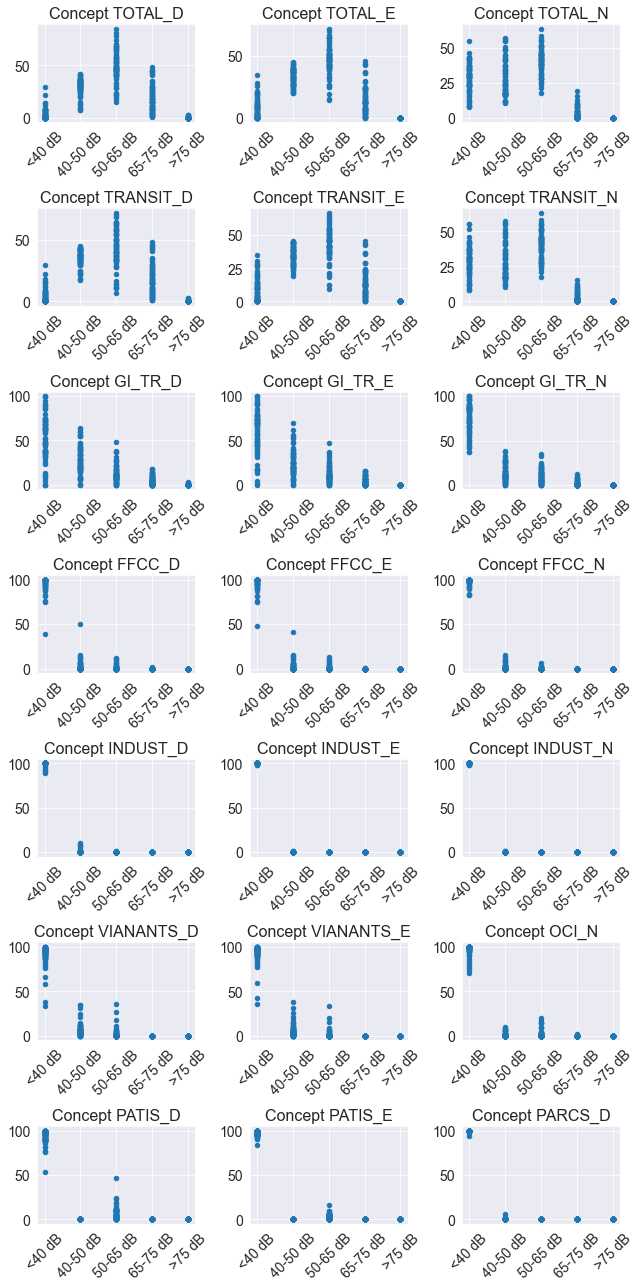

In [45]:
# Scatterplots for each type of noise source and time period
fig = plt.figure(figsize=(9, 18))
for i, concept in enumerate(concept_order):
    ax=plt.subplot(7, 3, i+1)  
    df_noise[df_noise['Concept'] == concept].plot(
        x='Noise_range_scale', y='Percentage_population',
        kind='scatter', ax=ax)
    plt.title(f'Concept {concept}')
    ax.set_xticks(range(0,5))
    ax.set_xticklabels(noise_dict.values(), rotation=45)
    plt.xlabel(None)
    plt.ylabel(None)
    plt.tight_layout()

It's evident that the population exposed to different noise levels varies significantly across different neighborhoods. For instance, in the case of total noise, there are neighborhoods where the majority of the population is not exposed to noise exceeding 50 dB during nighttime, while in others, it is the opposite, with a significant portion of the population being exposed to such noise.  
The influence of road traffic noise is most noticeable, with some neighborhoods having over 50% of the population exposed to noise levels exceeding 50 dB during the night. In nearly all neighborhoods, at any time, the percentage of the population not exposed to road traffic noise (levels below 40%) does not exceed 50%.  
On the other hand, the population is less affected by noise from railways, even less by industrial noise and  noise in parks. Pedestrian and recreational noise is noticeable in some neighborhoods.

Let's examine whether the distribution patterns of percentages of the population exposed to the different noise ranges differ in the most expensive and the least expensive neighborhoods.

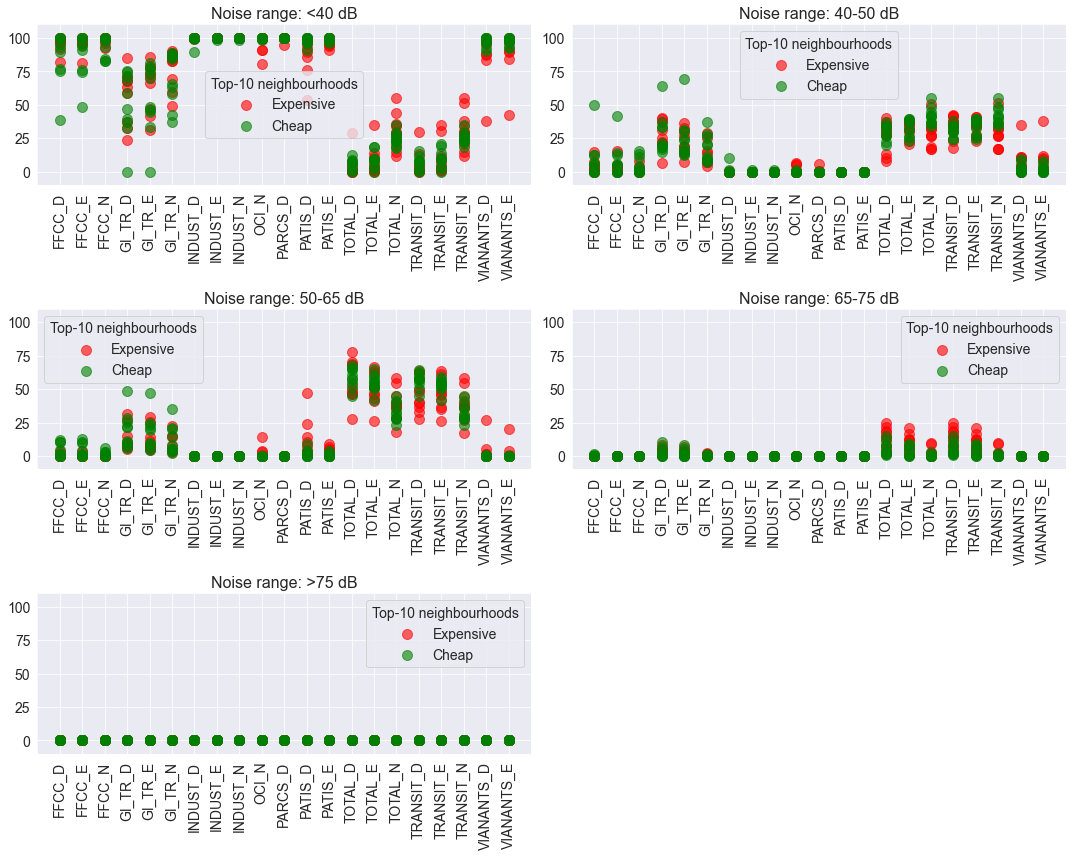

In [46]:
# Scatterplots for each level of noise
# in top 10 most expencive/cheapest neighbourhoods
fig = plt.figure(figsize=(15, 12))
for i, rang in enumerate(list(df_noise.Noise_range_scale.unique())):
    ax=plt.subplot(3, 2, i+1)  
    (df_noise[(df_noise['Noise_range_scale'] == rang) &
              (df_noise['Neighbourhood_code'].isin(expensive_nbhood_10))]
     .plot(x='Concept', y='Percentage_population', 
           color='r', kind='scatter', rot=90, s=100, alpha=0.6, ax=ax))   
    
    (df_noise[(df_noise['Noise_range_scale'] == rang) &
              (df_noise['Neighbourhood_code'].isin(cheap_nbhood_10))]
     .plot(x='Concept', y='Percentage_population', 
           color='g', kind='scatter', rot=90, s=100, alpha=0.6, ax=ax))
    plt.legend(['Expensive', 'Cheap'], title='Top-10 neighbourhoods', title_fontsize=14)
    plt.title(f'Noise range: {noise_dict[rang]}')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.ylim(-10, 110)
    plt.tight_layout()

It seems that there is no clear direct relationship between the rental price and the noise level in neighborhoods. However, some features can be highlighted:
- in the most expensive neighborhoods, there may be a higher percentage of the population that is NOT affected by road traffic noise. On the other hand, in these neighborhoods, there may be a lower percentage that is NOT affected by pedestrian, recreational, courtyard, and park noise;
- in the least expensive neighborhoods, the percentage of the population affected by moderate road traffic noise may be higher, but at higher road ttraffic noise levels (above 65 dB), more people may be affected in the expensive neighborhoods.

The relationship between rental prices and the percentage of the population affected by different noise levels can be examined later.

To facilitate the subsequent PCA analysis, let's transform the dataset from a long format to a wide format.

In [47]:
# reshape data to the wide format
# each 'Concept' has 5 'Noise_range_scale'
df_noise_wide = (df_noise
                 .pivot(index=df_noise.columns[0:-3],
                        columns=['Concept', 'Noise_range_scale'],
                        values='Percentage_population')
                 .reset_index()    # collapses multi-index
                 .rename_axis([None, None], axis=1))    # renames index

# Merge multi-level columns into single-level columns
df_noise_wide.columns = df_noise_wide.columns.map('_'.join).str.strip('_')

df_noise_wide

,District_code,District_name,Neighbourhood_code,Neighbourhood_name,FFCC_D_1,FFCC_D_2,FFCC_D_3,FFCC_D_4,FFCC_D_5,FFCC_E_1,FFCC_E_2,FFCC_E_3,FFCC_E_4,FFCC_E_5,FFCC_N_1,FFCC_N_2,FFCC_N_3,FFCC_N_4,FFCC_N_5,GI_TR_D_1,GI_TR_D_2,GI_TR_D_3,GI_TR_D_4,GI_TR_D_5,GI_TR_E_1,GI_TR_E_2,GI_TR_E_3,GI_TR_E_4,GI_TR_E_5,GI_TR_N_1,GI_TR_N_2,GI_TR_N_3,GI_TR_N_4,GI_TR_N_5,INDUST_D_1,INDUST_D_2,INDUST_D_3,INDUST_D_4,INDUST_D_5,INDUST_E_1,INDUST_E_2,INDUST_E_3,INDUST_E_4,INDUST_E_5,INDUST_N_1,INDUST_N_2,INDUST_N_3,INDUST_N_4,INDUST_N_5,OCI_N_1,OCI_N_2,OCI_N_3,OCI_N_4,OCI_N_5,PARCS_D_1,PARCS_D_2,PARCS_D_3,PARCS_D_4,PARCS_D_5,PATIS_D_1,PATIS_D_2,PATIS_D_3,PATIS_D_4,PATIS_D_5,PATIS_E_1,PATIS_E_2,PATIS_E_3,PATIS_E_4,PATIS_E_5,TOTAL_D_1,TOTAL_D_2,TOTAL_D_3,TOTAL_D_4,TOTAL_D_5,TOTAL_E_1,TOTAL_E_2,TOTAL_E_3,TOTAL_E_4,TOTAL_E_5,TOTAL_N_1,TOTAL_N_2,TOTAL_N_3,TOTAL_N_4,TOTAL_N_5,TRANSIT_D_1,TRANSIT_D_2,TRANSIT_D_3,TRANSIT_D_4,TRANSIT_D_5,TRANSIT_E_1,TRANSIT_E_2,TRANSIT_E_3,TRANSIT_E_4,TRANSIT_E_5,TRANSIT_N_1,TRANSIT_N_2,TRANSIT_N_3,TRANSIT_N_4,TRANSIT_N_5,VIANANTS_D_1,VIANANTS_D_2,VIANANTS_D_3,VIANANTS_D_4,VIANANTS_D_5,VIANANTS_E_1,VIANANTS_E_2,VIANANTS_E_3,VIANANTS_E_4,VIANANTS_E_5
0,1,Ciutat Vella,1,el Raval,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,87.87,8.25,2.09,1.79,0.00,90.52,6.12,1.74,1.62,0.00,95.32,2.02,2.66,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,75.89,7.50,16.47,0.14,0.00,100.00,0.00,0.00,0.00,0.00,95.90,0.00,4.10,0.00,0.00,98.00,0.00,2.00,0.00,0.00,7.73,34.36,48.69,9.22,0.00,21.45,24.86,46.66,7.03,0.00,42.75,17.51,38.09,1.65,0.00,11.30,37.89,41.77,9.04,0.00,25.92,26.42,40.78,6.88,0.00,46.18,20.98,32.51,0.33,0.00,57.69,24.25,18.06,0.00,0.00,59.13,25.84,15.03,0.00,0.00
1,1,Ciutat Vella,2,el Barri Gòtic,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,47.40,47.19,3.22,2.19,0.00,63.55,31.63,2.83,1.99,0.00,91.56,4.96,2.42,1.06,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,74.35,8.80,14.41,2.44,0.00,100.00,0.00,0.00,0.00,0.00,95.07,0.00,4.93,0.00,0.00,97.07,0.00,2.93,0.00,0.00,4.27,33.46,57.04,5.20,0.03,8.45,32.64,55.00,3.91,0.00,46.24,18.06,30.95,4.75,0.00,17.89,42.82,34.46,4.80,0.03,27.49,35.43,33.19,3.89,0.00,55.24,17.45,25.75,1.56,0.00,33.40,30.70,35.90,0.00,0.00,35.19,30.96,33.85,0.00,0.00
2,1,Ciutat Vella,3,la Barceloneta,96.51,3.49,0.00,0.00,0.00,96.09,3.88,0.03,0.00,0.00,99.23,0.77,0.00,0.00,0.00,58.52,30.90,9.02,1.20,0.36,66.09,26.26,6.24,1.41,0.00,82.69,13.73,2.73,0.85,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,90.54,5.61,3.85,0.00,0.00,100.00,0.00,0.00,0.00,0.00,98.89,0.00,1.11,0.00,0.00,98.89,0.00,1.11,0.00,0.00,1.23,27.19,67.75,3.47,0.36,5.92,29.80,61.83,2.45,0.00,19.94,50.82,28.39,0.85,0.00,1.79,32.15,62.25,3.45,0.36,7.35,34.71,55.50,2.44,0.00,20.57,51.50,27.08,0.85,0.00,83.52,11.20,5.28,0.00,0.00,84.24,11.93,3.83,0.00,0.00
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",99.56,0.17,0.27,0.00,0.00,99.57,0.15,0.28,0.00,0.00,99.65,0.09,0.26,0.00,0.00,71.00,21.39,5.07,2.54,0.00,79.09,14.02,4.59,2.30,0.00,90.34,4.35,4.41,0.90,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,80.65,5.30,13.98,0.07,0.00,99.81,0.19,0.00,0.00,0.00,98.79,0.00,1.21,0.00,0.00,99.56,0.00,0.44,0.00,0.00,4.98,40.28,46.53,8.21,0.00,13.64,36.61,43.33,6.42,0.00,43.70,17.09,37.18,2.03,0.00,12.98,42.30,36.71,8.01,0.00,30.13,27.31,36.37,6.19,0.00,51.50,16.92,30.08,1.50,0.00,38.14,34.69,27.17,0.00,0.00,42.49,37.60,19.91,0.00,0.00
4,2,Eixample,5,el Fort Pienc,99.70,0.30,0.00,0.00,0.00,99.63,0.37,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,29.70,41.89,17.07,10.20,1.14,35.19,38.43,16.47,9.91,0.00,60.85,19.73,14.76,4.66,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,87.90,0.00,12.10,0.00,0.00,94.10,0.00,5.90,0.00,0.00,0.17,30.41,23.48,44.80,1.14,

**Conclusions**:  
There is data on the percentage of the population exposed to different levels and sources of noise for 73 neighborhoods within 10 districts in Barcelona. 
- the percentage of the population was converted into a numerical format;
- the aggregate indicators (DEN) were excluded from the analysis, as in some cases, they seemed to have strange values (equal to zero when their components were not zero);
- the noise level ranges were expanded to 5 categories instead of the initial 10: 1) < 40 dB - faint noise, 2) 40-50 dB - soft noise, 3) 50-65 dB - moderate noise, 4) 65-75 dB - loud noise, 5) >= 75 dB - very loud noise;
- the dataset was transformed from a long format to a wide format: for each unique value of `Concept` there were 5 values of noise range, resulting in 105 new columns with percentages of the exposed population.  

Some observations from the data:
- a significant portion of the population in Barcelona is exposed to noise levels exceeding 50 dB, and during nighttime, there is no neighborhood where the noise level is below 40 dB for the majority of the population;
- neighborhoods vary considerably in terms of the percentages of the population exposed to different types of noise;
- the primary sources of noise are road traffic, while noise from industries and railways is relatively low, affecting a very small percentage of the population;
- it seems that noise pollution is not clearly and directly related to rental prices.

### Merge dataframes

In [48]:
# add to each neighbourhood from df_rent information about noise
df = df_rent.merge(df_noise_wide, how='left')
df

,Quarter,District_code,District_name,Neighbourhood_code,Neighbourhood_name,Price,Price_m2,Area,FFCC_D_1,FFCC_D_2,FFCC_D_3,FFCC_D_4,FFCC_D_5,FFCC_E_1,FFCC_E_2,FFCC_E_3,FFCC_E_4,FFCC_E_5,FFCC_N_1,FFCC_N_2,FFCC_N_3,FFCC_N_4,FFCC_N_5,GI_TR_D_1,GI_TR_D_2,GI_TR_D_3,GI_TR_D_4,GI_TR_D_5,GI_TR_E_1,GI_TR_E_2,GI_TR_E_3,GI_TR_E_4,GI_TR_E_5,GI_TR_N_1,GI_TR_N_2,GI_TR_N_3,GI_TR_N_4,GI_TR_N_5,INDUST_D_1,INDUST_D_2,INDUST_D_3,INDUST_D_4,INDUST_D_5,INDUST_E_1,INDUST_E_2,INDUST_E_3,INDUST_E_4,INDUST_E_5,INDUST_N_1,INDUST_N_2,INDUST_N_3,INDUST_N_4,INDUST_N_5,OCI_N_1,OCI_N_2,OCI_N_3,OCI_N_4,OCI_N_5,PARCS_D_1,PARCS_D_2,PARCS_D_3,PARCS_D_4,PARCS_D_5,PATIS_D_1,PATIS_D_2,PATIS_D_3,PATIS_D_4,PATIS_D_5,PATIS_E_1,PATIS_E_2,PATIS_E_3,PATIS_E_4,PATIS_E_5,TOTAL_D_1,TOTAL_D_2,TOTAL_D_3,TOTAL_D_4,TOTAL_D_5,TOTAL_E_1,TOTAL_E_2,TOTAL_E_3,TOTAL_E_4,TOTAL_E_5,TOTAL_N_1,TOTAL_N_2,TOTAL_N_3,TOTAL_N_4,TOTAL_N_5,TRANSIT_D_1,TRANSIT_D_2,TRANSIT_D_3,TRANSIT_D_4,TRANSIT_D_5,TRANSIT_E_1,TRANSIT_E_2,TRANSIT_E_3,TRANSIT_E_4,TRANSIT_E_5,TRANSIT_N_1,TRANSIT_N_2,TRANSIT_N_3,TRANSIT_N_4,TRANSIT_N_5,VIANANTS_D_1,VIANANTS_D_2,VIANANTS_D_3,VIANANTS_D_4,VIANANTS_D_5,VIANANTS_E_1,VIANANTS_E_2,VIANANTS_E_3,VIANANTS_E_4,VIANANTS_E_5
0,1,1,Ciutat Vella,1,el Raval,734.99,13.50,54.44,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,87.87,8.25,2.09,1.79,0.00,90.52,6.12,1.74,1.62,0.00,95.32,2.02,2.66,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,75.89,7.50,16.47,0.14,0.00,100.00,0.00,0.00,0.00,0.00,95.90,0.00,4.10,0.00,0.00,98.00,0.00,2.00,0.00,0.00,7.73,34.36,48.69,9.22,0.00,21.45,24.86,46.66,7.03,0.00,42.75,17.51,38.09,1.65,0.00,11.30,37.89,41.77,9.04,0.00,25.92,26.42,40.78,6.88,0.00,46.18,20.98,32.51,0.33,0.00,57.69,24.25,18.06,0.00,0.00,59.13,25.84,15.03,0.00,0.00
1,1,1,Ciutat Vella,2,el Barri Gòtic,905.26,14.14,64.02,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,47.40,47.19,3.22,2.19,0.00,63.55,31.63,2.83,1.99,0.00,91.56,4.96,2.42,1.06,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,74.35,8.80,14.41,2.44,0.00,100.00,0.00,0.00,0.00,0.00,95.07,0.00,4.93,0.00,0.00,97.07,0.00,2.93,0.00,0.00,4.27,33.46,57.04,5.20,0.03,8.45,32.64,55.00,3.91,0.00,46.24,18.06,30.95,4.75,0.00,17.89,42.82,34.46,4.80,0.03,27.49,35.43,33.19,3.89,0.00,55.24,17.45,25.75,1.56,0.00,33.40,30.70,35.90,0.00,0.00,35.19,30.96,33.85,0.00,0.00
2,1,1,Ciutat Vella,3,la Barceloneta,722.78,19.46,37.14,96.51,3.49,0.00,0.00,0.00,96.09,3.88,0.03,0.00,0.00,99.23,0.77,0.00,0.00,0.00,58.52,30.90,9.02,1.20,0.36,66.09,26.26,6.24,1.41,0.00,82.69,13.73,2.73,0.85,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,90.54,5.61,3.85,0.00,0.00,100.00,0.00,0.00,0.00,0.00,98.89,0.00,1.11,0.00,0.00,98.89,0.00,1.11,0.00,0.00,1.23,27.19,67.75,3.47,0.36,5.92,29.80,61.83,2.45,0.00,19.94,50.82,28.39,0.85,0.00,1.79,32.15,62.25,3.45,0.36,7.35,34.71,55.50,2.44,0.00,20.57,51.50,27.08,0.85,0.00,83.52,11.20,5.28,0.00,0.00,84.24,11.93,3.83,0.00,0.00
3,1,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",895.28,15.01,59.65,99.56,0.17,0.27,0.00,0.00,99.57,0.15,0.28,0.00,0.00,99.65,0.09,0.26,0.00,0.00,71.00,21.39,5.07,2.54,0.00,79.09,14.02,4.59,2.30,0.00,90.34,4.35,4.41,0.90,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,80.65,5.30,13.98,0.07,0.00,99.81,0.19,0.00,0.00,0.00,98.79,0.00,1.21,0.00,0.00,99.56,0.00,0.44,0.00,0.00,4.98,40.28,46.53,8.21,0.00,13.64,36.61,43.33,6.42,0.00,43.70,17.09,37.18,2.03,0.00,12.98,42.30,36.71,8.01,0.00,30.13,27.31,36.37,6.19,0.00,51.50,16.92,30.08,1.50,0.00,38.14,34.69,27.17,0.00,0.00,42.49,37.60,19.91,0.00,0.00
4,1,2,Eixample,5,el Fort Pienc,871.08,12.77,68.21,99.70,0.30,0.00,0.00,0.00,99.63,0.37,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,29.70,41.89,17.07,10.20,1.14,35.19,38.43,16.47,9.91,0.00,60.85,19.73,14.76,4.66,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,10

For some noise sourses, at certain ranges, the percentage of the population exposed to them is almost zero. We can remove these columns, keeping in mind that there is data on the population not affected by noise (noise range < 40 dB).

In [49]:
# Noise types where percentage of population < 1% in all neighbourhoods
idx = list(df.iloc[:, 8:].sum().index[df.iloc[:, 8:].sum() <= 1])
df[idx].agg(['sum', 'max']).T

,sum,max
FFCC_D_5,0.00,0.00
FFCC_E_5,0.00,0.00
FFCC_N_4,0.20,0.04
FFCC_N_5,0.00,0.00
GI_TR_N_5,0.00,0.00
INDUST_D_4,0.00,0.00
INDUST_D_5,0.00,0.00
INDUST_E_3,0.00,0.00
INDUST_E_4,0.00,0.00
INDUST_E_5,0.00,0.00


All noise sources do not exceed a level of 75 dB, and noise from industries and courtyards is minimal.

In [50]:
# Drop columns where sum <= 1
df = df.drop(idx, axis=1)
df.shape

(273, 85)

Let's examine how prices change with different percentages of the population exposed to various noise types. We will focus on the 'noise types' where some differences between expensive and inexpensive neighborhoods were observed, paying particular attention to the absence of noise (<40 dB) and strong noise (65-75 dB), especially from road traffic.

In [51]:
# "noise types" to evaluate
cnames ={'TOTAL_N_1': '< 40 dB, total at night', 
         'TOTAL_N_4': '65-75 dB, total at night', 
         'TRANSIT_D_4': '65-75 dB, daytime road traffic', 
         'TRANSIT_N_1': '<40 dB, road traffic at night', 
         'TRANSIT_N_4': '65-75 dB, road traffic at night'}

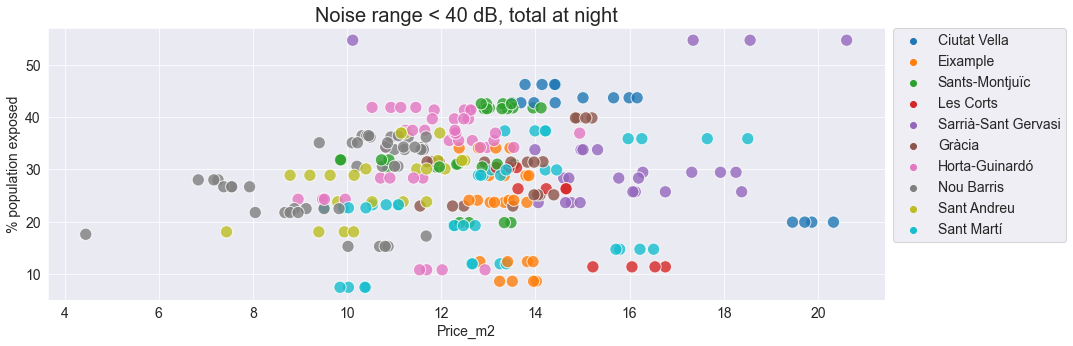

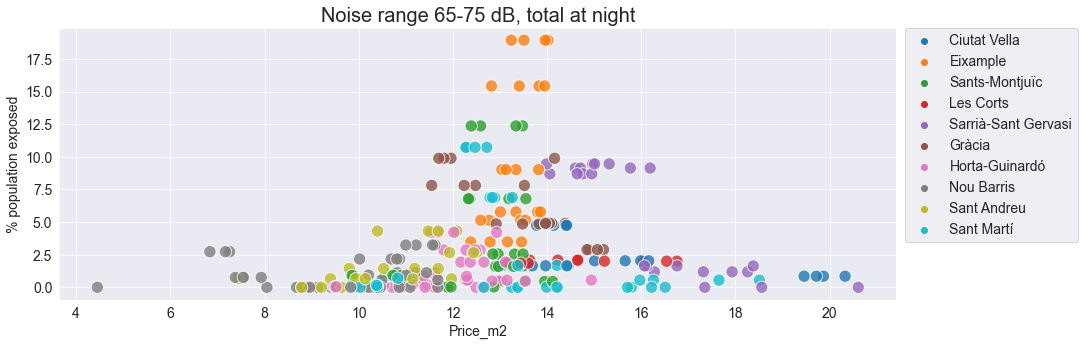

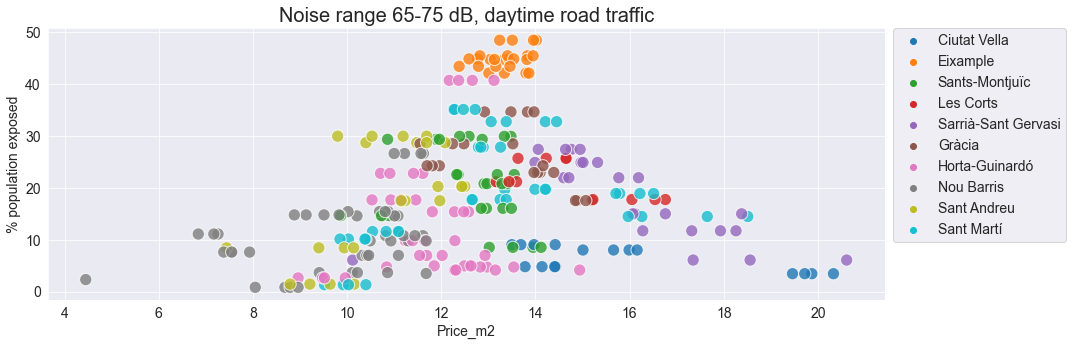

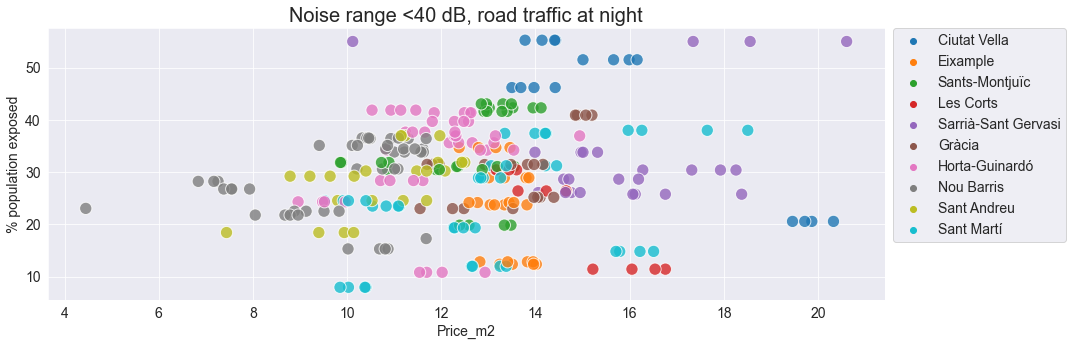

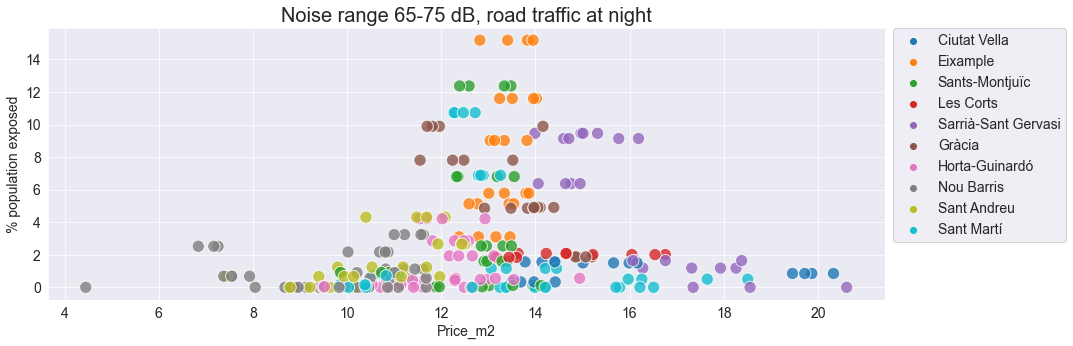

In [52]:
# scatterplots
for key, value in cnames.items():
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=df, x='Price_m2', y=key, 
                    hue='District_name', s=150, alpha=0.8)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    plt.title(f'Noise range {value}', fontsize=20)
    plt.ylabel('% population exposed')
    plt.show()

It's noticeable that the percentage of the population exposed to high noise levels (65-75 dB) is significantly lower in neighborhoods with the highest rental prices compared to those with average prices. However, even in cheap neighborhoods, it is also lower.  
The percentage of the population not exposed to noise (levels below 40 dB) varies significantly across different rental prices.  
Overall, it can be emphasized once again that the relationship between rental prices and noise levels in neighborhoods is not direct and obvious.

**Conclusion:**  
We now have a data set with 85 columns, 80-81 of which can be features. Columns in which the percentage of the population exposed to specific noise was zero in all neighborhoods were removed.
It is natural to assume that the target variable is the rental price, specifically the price per square meter. However, a classification task could also be possible, such as assigning an object to a specific neighborhood or district, but this seems less likely.

## PCA
PCA is one of the simplest and most fundamental dimensionality reduction techniques. It is a linear dimensionality reduction technique which converts a set of *correlated* features in the high dimensional space into a series of uncorrelated features (principal components) in the low dimensional space. PCA transforms the data in such a way that the first component tries to explain maximum variance from the original data. PCA is an unsupervised algorithm.  
Through PCA analysis, we can create a new feature space, for instance, to optimize and enhance the performance of models for predicting rental prices or classifying objects into neighborhoods/districts. This feature engineering can be valuable in improving the accuracy and efficiency of the models.

Let's identify the features and the target variable. As the target variable, we will specify the price per square meter. From the features, we will remove the district/neighborhood names, district codes, and the rental price.

In [53]:
# target - rental price per m2 
target = df.Price_m2

In [54]:
# features: all types of noise sourses
features = df.drop(['District_code', 'District_name',
                    'Neighbourhood_name', 'Price', 'Price_m2'], axis=1)
features.shape

(273, 80)

### Data standartization 
Before conducting the analysis, it is necessary to standardize the data as they are in different scales. This process ensures that all features are on a comparable scale, which is a common practice in PCA to avoid any undue influence of features with larger scales on the results.

In [55]:
# Create scaler and transform features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(features)

**Limitations** of PCA include not being robust to outliers, scale-sensitive and linear relationship assumption. We can use PCA when the features are strongly correlated and PCA does not perform well when features share a non-linear relationship.

We have seen that there are no significant outliers in features, let's see how they correlate.

### Linear correlation between features

<AxesSubplot:>

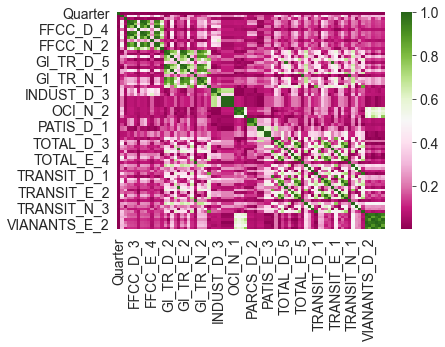

In [56]:
# heatmap of abs values of Pearson correlation coefficients between features
sns.heatmap(abs(pd.DataFrame(data_scaled, columns=features.columns).corr()), cmap="PiYG")

It's evident that there are highly correlated features, likely representing the same noise types at different times or similar noise types. PCA may not perform well when features share a non-linear relationship and would require the relationship to be transformed into a linear one using methods such as log transformation, etc. Since there are correlated features, we can apply PCA without transforming them. However, it's important to keep in mind that the interpretation of the principal components may be challenging due to possible the non-linear relationships.

In [57]:
# Create a PCA instance
pca = PCA(n_components=None)

# Fit the PCA model to scaled data
pca.fit(data_scaled)

PCA()

Let’s have a look at how much percentage of variance is explained by each principal component and how many principal components do we need to retain maximum variance from our original data. 

In [58]:
# explained variance ratio
explained_variance = pca.explained_variance_ratio_

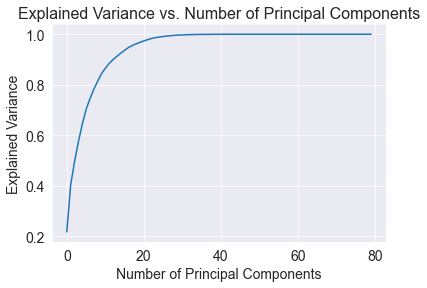

In [59]:
# Check the explained variance ratio to decide how many components to keep
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [60]:
# Specify the number of components to keep
n_components = np.argmax(np.cumsum(explained_variance) >= 0.945)+1
print('Number of principal components explaing 95% of varience:')
n_components

Number of principal components explaing 95% of varience:


17

In [61]:
for i in range(1, len(explained_variance)):
    if np.cumsum(explained_variance)[i-1]*100 > 99:
        break
    print(f'The percentage of varience explained by principal component {i} is {round(np.cumsum(explained_variance)[i-1]*100)} %')

The percentage of varience explained by principal component 1 is 22 %
The percentage of varience explained by principal component 2 is 40 %
The percentage of varience explained by principal component 3 is 49 %
The percentage of varience explained by principal component 4 is 57 %
The percentage of varience explained by principal component 5 is 64 %
The percentage of varience explained by principal component 6 is 70 %
The percentage of varience explained by principal component 7 is 74 %
The percentage of varience explained by principal component 8 is 78 %
The percentage of varience explained by principal component 9 is 81 %
The percentage of varience explained by principal component 10 is 84 %
The percentage of varience explained by principal component 11 is 86 %
The percentage of varience explained by principal component 12 is 88 %
The percentage of varience explained by principal component 13 is 90 %
The percentage of varience explained by principal component 14 is 91 %
The percentage 

As we can see, the percentage of variance explained by the first principal component is the highest, accounting for 22%, followed by the second principal component at 18%. The remaining 56 principal components explain only 1% of the variance. Using the first 9 principal components retains 80% of the total variance, and using the first 17 principal components retains 95% of the total variance.

So, we can reduce our data from 80 dimensions to 17 dimensions using PCA.

Principal components are the newly formed features resulting from an orthogonal linear transformation of our original data. It's important to understand which features from our original data have the most influence on these principal components. To determine this, we can examine the absolute values of the eigen vector components. Larger absolute values indicate that a specific feature contributes more to that principal component. This analysis helps us interpret and understand the underlying factors driving the principal components.

In [62]:
# examine the loadings for the first 5 principal components
pc_df = pd.DataFrame(abs(pca.components_[:5]), columns=features.columns)
pc_df

,Quarter,Neighbourhood_code,Area,FFCC_D_1,FFCC_D_2,FFCC_D_3,FFCC_D_4,FFCC_E_1,FFCC_E_2,FFCC_E_3,FFCC_E_4,FFCC_N_1,FFCC_N_2,FFCC_N_3,GI_TR_D_1,GI_TR_D_2,GI_TR_D_3,GI_TR_D_4,GI_TR_D_5,GI_TR_E_1,GI_TR_E_2,GI_TR_E_3,GI_TR_E_4,GI_TR_E_5,GI_TR_N_1,GI_TR_N_2,GI_TR_N_3,GI_TR_N_4,INDUST_D_1,INDUST_D_2,INDUST_D_3,INDUST_E_1,INDUST_E_2,INDUST_N_1,INDUST_N_2,OCI_N_1,OCI_N_2,OCI_N_3,OCI_N_4,PARCS_D_1,PARCS_D_2,PARCS_D_3,PATIS_D_1,PATIS_D_3,PATIS_E_1,PATIS_E_3,TOTAL_D_1,TOTAL_D_2,TOTAL_D_3,TOTAL_D_4,TOTAL_D_5,TOTAL_E_1,TOTAL_E_2,TOTAL_E_3,TOTAL_E_4,TOTAL_E_5,TOTAL_N_1,TOTAL_N_2,TOTAL_N_3,TOTAL_N_4,TRANSIT_D_1,TRANSIT_D_2,TRANSIT_D_3,TRANSIT_D_4,TRANSIT_D_5,TRANSIT_E_1,TRANSIT_E_2,TRANSIT_E_3,TRANSIT_E_4,TRANSIT_E_5,TRANSIT_N_1,TRANSIT_N_2,TRANSIT_N_3,TRANSIT_N_4,VIANANTS_D_1,VIANANTS_D_2,VIANANTS_D_3,VIANANTS_E_1,VIANANTS_E_2,VIANANTS_E_3
0,0.00,0.00,0.08,0.02,0.02,0.03,0.00,0.03,0.03,0.03,0.00,0.03,0.04,0.01,0.20,0.18,0.15,0.19,0.11,0.20,0.19,0.16,0.19,0.05,0.20,0.18,0.18,0.17,0.01,0.01,0.01,0.05,0.05,0.05,0.05,0.03,0.03,0.03,0.04,0.06,0.06,0.05,0.07,0.07,0.11,0.11,0.15,0.04,0.08,0.18,0.12,0.18,0.07,0.08,0.18,0.05,0.17,0.00,0.11,0.15,0.17,0.01,0.09,0.18,0.12,0.19,0.11,0.08,0.18,0.05,0.17,0.01,0.13,0.15,0.09,0.10,0.08,0.09,0.10,0.08
1,0.00,0.17,0.01,0.19,0.18,0.17,0.09,0.19,0.18,0.17,0.07,0.18,0.18,0.12,0.04,0.00,0.15,0.06,0.02,0.05,0.02,0.14,0.07,0.00,0.08,0.10,0.10,0.09,0.13,0.13,0.13,0.09,0.09,0.09,0.09,0.10,0.09,0.10,0.07,0.06,0.06,0.06,0.01,0.01,0.03,0.03,0.02,0.15,0.18,0.12,0.04,0.00,0.12,0.19,0.13,0.00,0.12,0.13,0.02,0.12,0.00,0.21,0.20,0.12,0.04,0.03,0.12,0.20,0.13,0.00,0.12,0.13,0.02,0.11,0.11,0.10,0.10,0.10,0.10,0.10
2,0.00,0.00,0.01,0.17,0.15,0.18,0.06,0.18,0.16,0.18,0.12,0.18,0.19,0.08,0.00,0.00,0.01,0.01,0.04,0.00,0.01,0.01,0.00,0.06,0.01,0.02,0.04,0.00,0.10,0.09,0.09,0.01,0.01,0.01,0.01,0.23,0.22,0.22,0.17,0.08,0.08,0.07,0.10,0.10,0.18,0.18,0.03,0.06,0.02,0.07,0.03,0.02,0.10,0.00,0.06,0.06,0.06,0.16,0.12,0.03,0.04,0.03,0.09,0.06,0.03,0.06,0.05,0.07,0.06,0.06,0.09,0.16,0.09,0.00,0.22,0.19,0.23,0.22,0.21,0.22
3,0.00,0.07,0.00,0.09,0.08,0.11,0.06,0.10,0.08,0.11,0.08,0.11,0.11,0.08,0.16,0.20,0.10,0.03,0.17,0.15,0.19,0.09,0.04,0.14,0.11,0.13,0.06,0.06,0.01,0.01,0.01,0.05,0.05,0.05,0.05,0.15,0.14,0.15,0.17,0.01,0.01,0.01,0.01,0.01,0.08,0.08,0.03,0.08,0.17,0.14,0.16,0.00,0.05,0.14,0.11,0.14,0.10,0.17,0.11,0.03,0.03,0.08,0.14,0.14,0.16,0.06,0.09,0.11,0.11,0.14,0.07,0.17,0.12,0.01,0.18,0.17,0.19,0.18,0.16,0.19
4,0.00,0.04,0.05,0.14,0.13,0.13,0.15,0.14,0.13,0.13,0.11,0.15,0.12,0.21,0.06,0.05,0.07,0.06,0.03,0.07,0.06,0.07,0.05,0.02,0.08,0.08,0.07,0.04,0.23,0.22,0.18,0.25,0.25,0.25,0.25,0.00,0.02,0.00,0.03,0.05,0.05,0.05,0.19,0.19,0.11,0.11,0.07,0.21,0.06,0.08,0.04,0.05,0.16,0.05,0.07,0.02,0.05,0.10,0.17,0.00,0.07,0.11,0.01,0.08,0.04,0.06,0.11,0.04,0.07,0.02,0.06,0.10,0.18,0.00,0.02,0.00,0.05,0.02,0.00,0.05


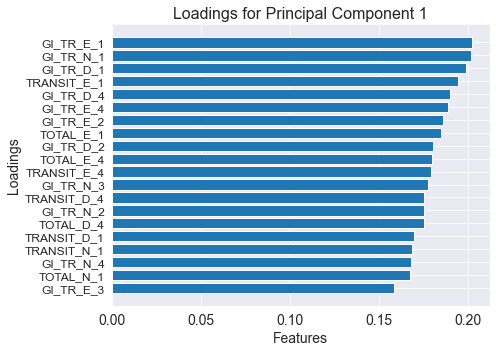

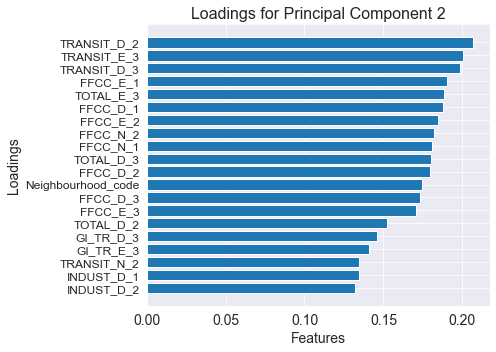

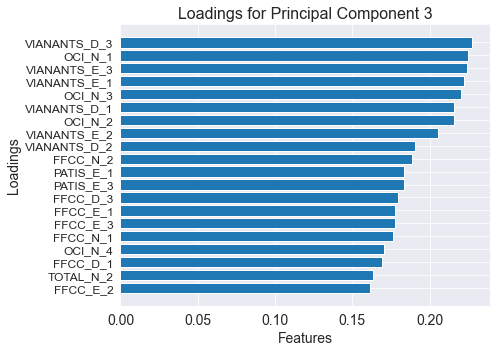

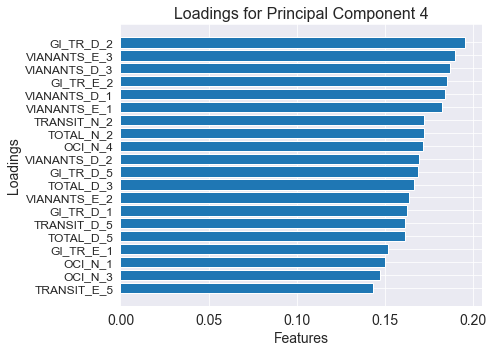

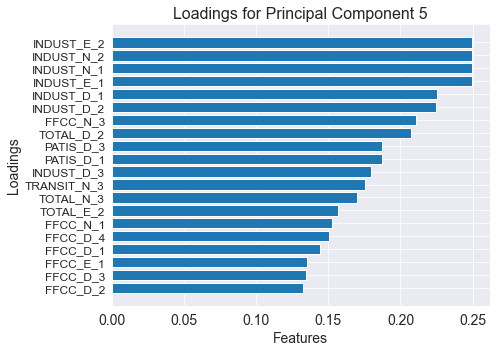

In [63]:
# visualization of the loadings for the first 5 principal component
for i in range(len(pc_df)):
    plt.figure(figsize=(7, 5))
    plt.barh(pc_df.iloc[i].sort_values().tail(20).index,
             pc_df.iloc[i].sort_values().tail(20))
    plt.yticks(fontsize=12)
    plt.xlabel('Features')
    plt.ylabel('Loadings')
    plt.title(f'Loadings for Principal Component {i+1}')
    plt.tight_layout()
    plt.show()

It's not evident that specific features have a pronounced influence on the principal components. However, it's clear that road traffic noise or its absence plays a significant role in the principal components, along with pedestrian and recreational noise, the absence of noise from railways and industries.

### Transform the data
Let's obtain the transformed dataset with 17 features instead of the original 80. This dataset will represent the data in a lower-dimensional space using the first 17 principal components obtained through PCA.

In [64]:
# Transform the data
reduced_data = pca.transform(data_scaled)[:, :n_components]
pd.DataFrame(reduced_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-7.29,-4.44,5.15,3.32,0.29,-0.34,0.03,0.25,-0.50,-0.71,-0.85,-0.98,0.64,0.78,-1.07,-0.09,-1.62
1,-6.96,-6.73,9.38,8.44,1.99,0.56,-1.60,-1.97,0.40,0.88,1.60,0.51,-0.13,0.62,-1.20,-0.16,3.19
2,-2.93,1.29,-0.79,3.87,1.30,-0.06,-0.03,-1.13,2.32,0.18,-1.24,-1.60,-0.29,1.01,-0.98,1.02,-2.37
3,-7.07,-5.62,6.43,4.89,1.82,0.59,-1.64,-1.37,-1.25,0.66,-1.52,0.51,-0.38,1.25,-0.77,-0.69,-0.88
4,6.60,-3.56,0.08,-0.91,-1.01,0.67,0.99,-0.28,-0.65,-0.91,-0.34,1.22,-0.58,1.44,-0.51,-1.26,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,5.79,9.33,5.33,-0.27,-1.79,-7.97,3.52,-2.30,-2.07,6.70,0.52,-2.11,0.57,-0.97,1.18,-1.20,-0.27
269,-2.32,8.95,3.01,-2.85,4.98,1.54,1.78,0.55,3.25,0.56,-1.19,0.49,-0.20,0.34,1.65,2.45,0.68
270,4.71,10.18,3.76,0.48,-2.68,-0.81,-3.21,0.20,-2.28,-2.86,0.59,-0.73,-2.89,-1.13,0.72,0.56,1.59
271,-1.21,3.22,-1.01,-1.29,0.59,-1.02,-0.94,-0.72,1.29,-0.31,-0.07,-0.10,0.91,0.55,2.03,0.55,0.12


## Conclusion:
The exploratory analysis of rental prices and the percentages of the population exposed to different noise levels in the city of Barcelona, followed by the PCA analysis of the merged datasets for dimension reduction, have been completed. This analysis offers valuable insights into the possible connection between noise levels and rental prices, as well as the potential for enhancing modeling and analysis through feature engineering and dimensionality reduction.

1. **Pre-processing of Data**:
- Data for both rental prices and noise exposure were collected for 73 neighborhoods within 10 districts in Barcelona.
- For rental prices, data covered the four quarters of 2017, including the average total rental price and rental price per m2.
- Noise exposure data covered the period from 2012 to 2017, including 26 "types of noise" and 10 noise levels.
- Missing values were addressed by removing rows with missing price information;
- Based on the total price and price per square meter, a new feature, 'Area,' was created;
- Aaggregate indicators (DEN) from noise exposure data were excluded from the analysis;
- Noise level ranges were expanded to 5 categories instead of the initial 10: 1) < 40 dB - faint noise, 2) 40-50 dB - soft noise, 3) 50-65 dB - moderate noise, 4) 65-75 dB - loud noise, 5) >= 75 dB - very loud noise;
- The noise exposure dataset was restructured from a long format to a wide format, where combinations of noise concepts and noise range categories were converted into columns;
- Columns where the percentage of the population exposed to specific noise levels was consistently zero in all neighborhoods were eliminated from the dataset;
- The two datasets were merged with the rental price dataset being the “base” dataset.

2. **EDA Insights**:
- Rental prices were found to vary significantly among neighborhoods in general and among neighborhoods within the same district, with the most expensive district being Sarrià-Sant Gervasi and the cheapest being Nou Barris.
- Rental prices, in general, were influenced by the quarter (e.g. increase in the 3rd quarter during the peak tourist season). For some neighborhoods, the price difference between quarters can be much more pronounced than for others;
- Substantial portion of the population in Barcelona experiences noise levels surpassing 50 dB. Furthermore, during nighttime, there is no neighborhood where the noise level falls below 40 dB for the majority of the population.
- Noise exposure data showed that different neighborhoods experienced varying levels of noise pollution, with road traffic noise being the most prominent source. Noise from industries and railways is relatively low, affecting a very small percentage of the population;
- It seems, that there is no direct and clear relationship between rental prices and noise levels in neighborhoods.

3. **PCA Results**:
- PCA was conducted to create a lower-dimensional feature space for potential model improvement;
- The target variable was determined to be the rental price per square meter, and the features considered for analysis included: Quarter, Neighborhood code, Area, and all columns related to the percentages of the population exposed to various types and levels of noise;
- Before conducting the PCA, the features were standardized by removing the mean and scaling to unit variance;
- The first 9 principal components retained 80% of the total variance, and the first 17 principal components retained 95% of the total variance;
- The main factors influencing the principal components included percentages of population exposed to road traffic noises, pedestrian and recreational noises, and the absence of noise from railways and industries.
- Transformed dataset with 17 features instead of the original 80 was obtained. This dataset represented the data in a lower-dimensional space using the first 17 principal components obtained through PCA.

4. **Possible Actions / Limitations**:
- It is possible that we could have analyzed only the aggregated noise exposure indicators (DEN) and nighttime data, as these might be more relevant to the specific analysis goals;
- Depending on the ultimate objectives, we could choose to focus exclusively on the indicators of total noise exposure;
- Not all features in the final dataset exhibit linear relationships, which can limit the effectiveness of PCA in capturing the underlying variance in the data. This non-linearity should be considered when applying dimensionality reduction techniques.